In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors
import numpy as np

# Questão 1 - Titanic

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [3]:
def create_pallette():
  x,y,c = zip(*np.random.rand(30,3)*4-2)

  norm=plt.Normalize(-2,2)
  trop = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightseagreen","white","orchid"])
  trop_rev = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orchid","white","lightseagreen"])
  aquas = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", 'lightcyan', "paleturquoise", "lightseagreen", "teal"])
  return trop, trop_rev, aquas 
trop, trop_rev, aquas = create_pallette()

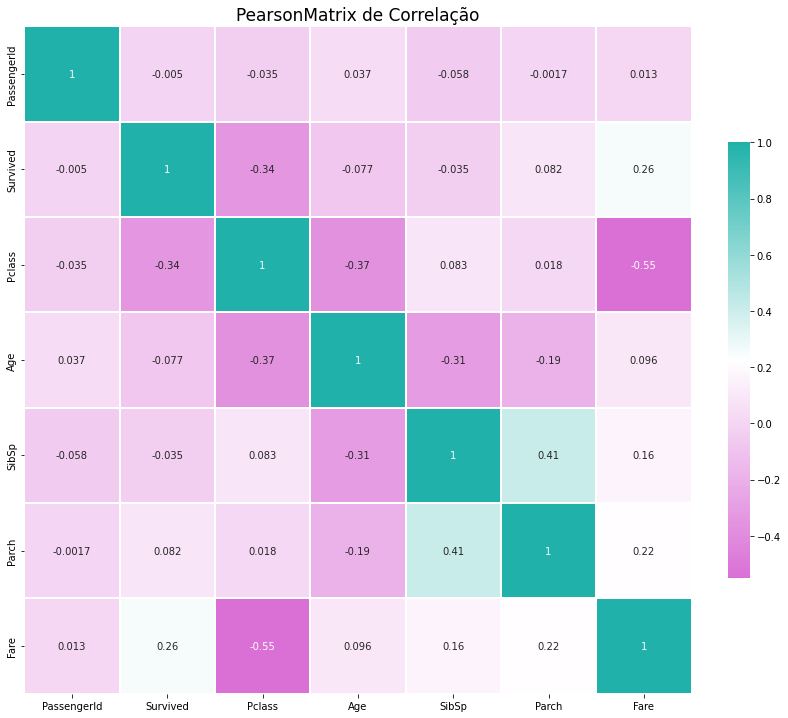

In [4]:
def get_correlation_matrix(data : pd.DataFrame, method_corr: str, palette ):
  numerical_variables = list(data.select_dtypes(include=['float64', "int"]).columns)
  data_num = data[numerical_variables].copy()
  corr_numbers = data_num.corr(method = method_corr)


       
  fig, ax = plt.subplots(figsize=(13,15))
  sns.heatmap(corr_numbers,
              
                annot = True,
                square=True,
                linewidth=1,# space between cells
                cmap= palette,
                cbar_kws={'fraction' : 0.03}, # shrink colour bar
                ax = ax,
              );

  ax.set_title(method_corr.capitalize() +"Matrix de Correlação", fontsize=17);
get_correlation_matrix(train, 'pearson', trop_rev)

In [5]:
train[train['Sex'] == 'female']['Survived'].value_counts()

1    233
0     81
Name: Survived, dtype: int64

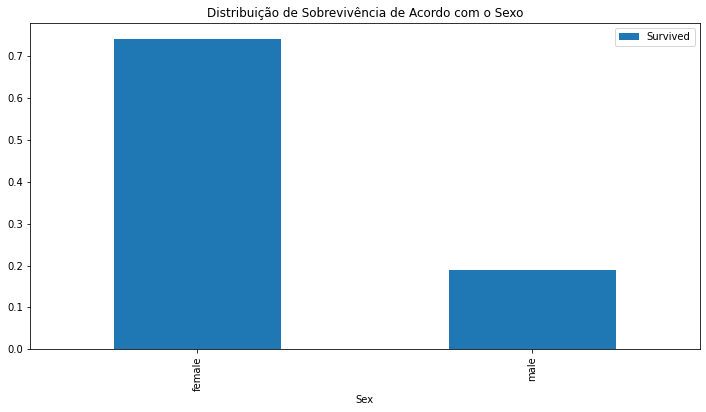

In [6]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar(figsize = (12,6))
plt.title('Distribuição de Sobrevivência de Acordo com o Sexo')
plt.show()

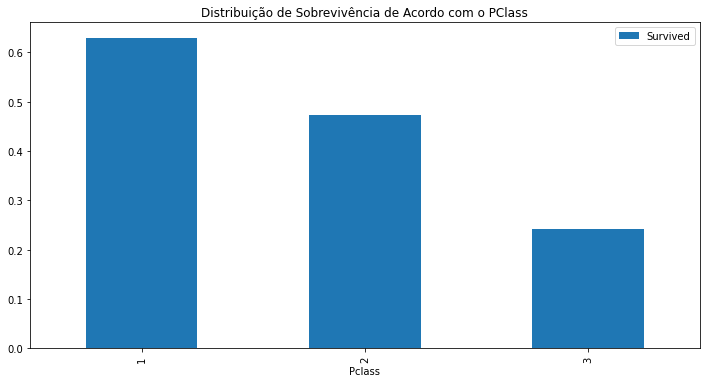

In [7]:
class_pivot = train.pivot_table(index = 'Pclass', values = 'Survived')
class_pivot.plot.bar(figsize = (12,6))
plt.title('Distribuição de Sobrevivência de Acordo com o PClass')
plt.show()

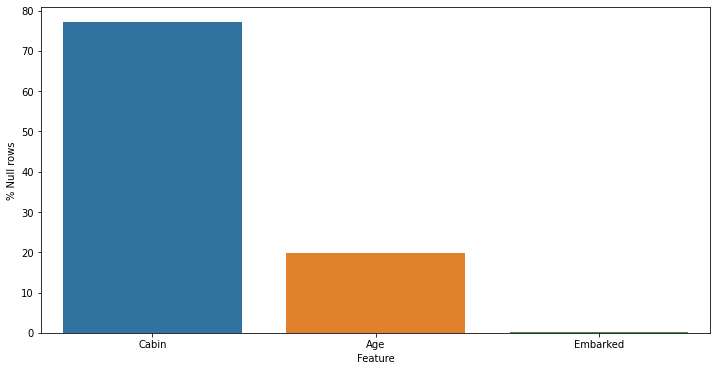

,Feature,% Null rows
0,Cabin,77.104377
1,Age,19.865320
2,Embarked,0.224467


In [8]:
def null_cols(data: pd.DataFrame) -> pd.DataFrame:

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    plt.figure(figsize =(12,6))
    sns.barplot(x = 'Feature', y = '% Null rows', data = nulls)
    plt.show()
    return nulls
null_cols(train)

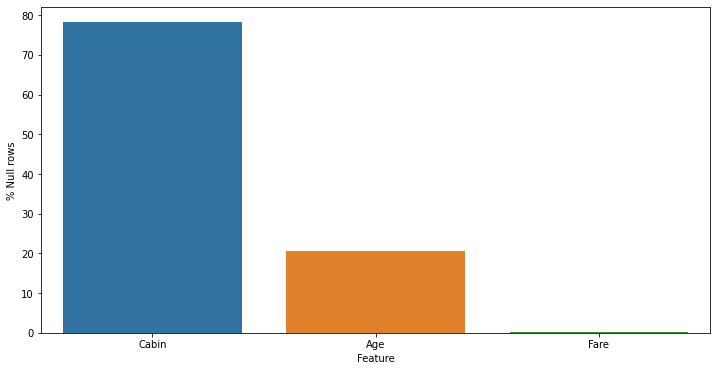

,Feature,% Null rows
0,Cabin,78.229665
1,Age,20.574163
2,Fare,0.239234


In [9]:
null_cols(test)

## Preenchendo os Valores

In [10]:
train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [11]:
def process_age(df: pd.DataFrame) -> pd.DataFrame:
  median_age = df['Age'].median()
  df["Age"] = df["Age"].fillna(median_age)
  return df
def process_fare(df: pd.DataFrame) -> pd.DataFrame:
  median_age = df['Fare'].median()
  df["Fare"] = df["Fare"].fillna(median_age)
  return df 

def process_embarked(df:pd.DataFrame) -> pd.DataFrame:
  unkown = 'Unkown'
  df['Embarked'] = df['Embarked'].fillna(unkown)
  return df
def drop_columns(df: pd.DataFrame, columns: any) -> pd.DataFrame:
  df = df.drop(columns, axis = 1)
  return df 

train = process_age(train)
train = process_embarked(train)
test = process_age(test)
test = process_fare(test)

In [12]:
train = drop_columns(train,'Cabin')
test = drop_columns(test, 'Cabin')

## Feature Engineering

In [13]:
def label_age(df: pd.DataFrame) -> pd.DataFrame:
  cut_points = [0,12,18,35,60,100]
  label_names = ["Child","Teenager","Young Adult","Adult","Senior"]
  df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
  return df 
  
def label_fare(df : pd.DataFrame) -> pd.DataFrame:
  cut_points = [0,12,50,100,1000]
  label_names = ['0-12','12-50','50-100','100+']
  df['Fare_categories'] = pd.cut(df['Fare'], cut_points, labels = label_names)
  return df

train = label_age(train)
test = label_age(test)

train = label_fare(train)
test = label_fare(test)

In [14]:
def process_name(df:pd.DataFrame) -> pd.DataFrame:
  titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
  }
  extracted_titles =  df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
  df['Title'] = extracted_titles.map(titles)
  return df 

train = process_name(train)
test = process_name(test)


In [15]:
def create_dummies(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
  dummies = pd.get_dummies(df[column_name],prefix=column_name)
  df = pd.concat([df,dummies],axis=1)
  df = drop_columns(df, column_name)
  return df

In [16]:
columns = ['Embarked','Age_categories','Fare_categories','Sex','Title']
for col in columns:
  train = create_dummies(train, col)
  test = create_dummies(test, col)


In [17]:
columns_to_drop = ['PassengerId','Name','Ticket']
for col in columns_to_drop:
  train = drop_columns(train, col)
  test = drop_columns(test, col)

In [18]:
train

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unkown,...,Fare_categories_50-100,Fare_categories_100+,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0,3,22.0,1,0,7.2500,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1,1,38.0,1,0,71.2833,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
4,0,3,35.0,0,0,8.0500,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
887,1,1,19.0,0,0,30.0000,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
888,0,3,28.0,1,2,23.4500,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
889,1,1,26.0,0,0,30.0000,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


## Construção do Modelo

In [19]:
X = drop_columns(train,'Survived')
y = train['Survived']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(X,y, test_size = 0.25, random_state = 42)

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_eval = sc.transform(X_eval)

In [22]:
X_train.shape

(668, 26)

In [23]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(units = 26, input_shape = (26,), activation = 'relu'))
model.add(Dense(units = 26,  activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, validation_data = (X_eval,y_eval), batch_size=10, epochs=150, verbose=2)

Epoch 1/150
67/67 - 4s - loss: 0.5975 - accuracy: 0.7275 - val_loss: 0.5307 - val_accuracy: 0.7623 - 4s/epoch - 56ms/step
Epoch 2/150
67/67 - 0s - loss: 0.4731 - accuracy: 0.7919 - val_loss: 0.4829 - val_accuracy: 0.7623 - 187ms/epoch - 3ms/step
Epoch 3/150
67/67 - 0s - loss: 0.4363 - accuracy: 0.8219 - val_loss: 0.4727 - val_accuracy: 0.7892 - 181ms/epoch - 3ms/step
Epoch 4/150
67/67 - 0s - loss: 0.4176 - accuracy: 0.8234 - val_loss: 0.4711 - val_accuracy: 0.8072 - 185ms/epoch - 3ms/step
Epoch 5/150
67/67 - 0s - loss: 0.4074 - accuracy: 0.8368 - val_loss: 0.4700 - val_accuracy: 0.7892 - 180ms/epoch - 3ms/step
Epoch 6/150
67/67 - 0s - loss: 0.3962 - accuracy: 0.8473 - val_loss: 0.4651 - val_accuracy: 0.8117 - 185ms/epoch - 3ms/step
Epoch 7/150
67/67 - 0s - loss: 0.3901 - accuracy: 0.8548 - val_loss: 0.4817 - val_accuracy: 0.7937 - 187ms/epoch - 3ms/step
Epoch 8/150
67/67 - 0s - loss: 0.3848 - accuracy: 0.8458 - val_loss: 0.4631 - val_accuracy: 0.8161 - 183ms/epoch - 3ms/step
Epoch 9/15

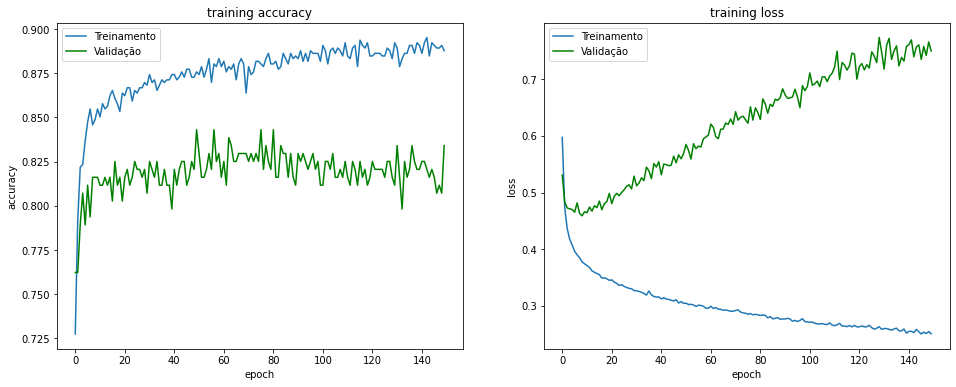

In [24]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
yhat =model.predict(X_eval)
confusion = confusion_matrix(y_eval,np.round(yhat))
confusion

array([[115,  19],
       [ 18,  71]])

In [27]:
print(classification_report(y_eval, np.round(yhat)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       134
           1       0.79      0.80      0.79        89

    accuracy                           0.83       223
   macro avg       0.83      0.83      0.83       223
weighted avg       0.83      0.83      0.83       223



# Questão 2 - MNIST

## RNA

In [28]:
from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [29]:
def load_and_treat_data() -> pd.DataFrame:
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  pixels = X_train.shape[1] * X_train.shape[2]
  X_train = X_train.reshape(X_train.shape[0],pixels).astype('float32') # transformando as imagens 28*28 para um vetor de tamanho 784 para cada imagem
  X_test = X_test.reshape(X_test.shape[0], pixels).astype("float32")
  #Normalização das entradas de 0-255 à 0-1
  X_train = X_train / 255
  X_test = X_test / 255
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_and_treat_data()

11501568/11490434 [==============================] - 0s 0us/step


In [30]:
model = Sequential()
model.add(Dense(28,input_dim=784, activation = 'relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 28)                21980     
                                                                 
 dense_4 (Dense)             (None, 25)                725       
                                                                 
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dense_6 (Dense)             (None, 10)                260       
                                                                 
Total params: 23,615
Trainable params: 23,615
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3690 - accuracy: 0.8927 - val_loss: 0.1981 - val_accuracy: 0.9422
Epoch 2/20
1875/1875 [================

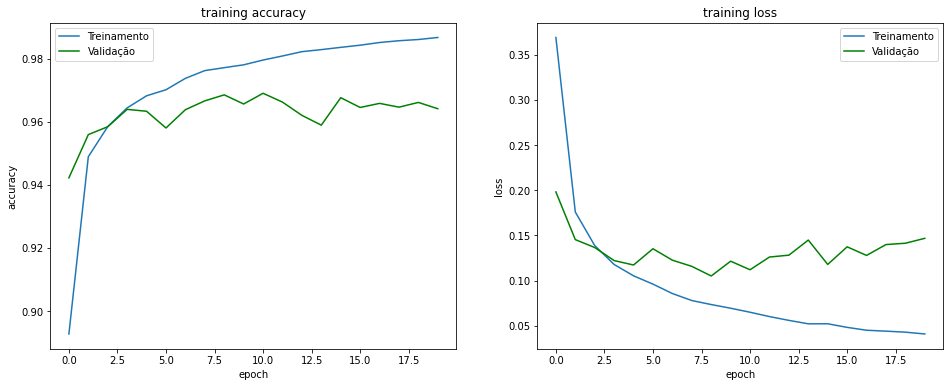

In [31]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.xlabel('epoch')
plt.show()

In [32]:
yhat = model.predict(X_test)
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat,axis=1))
confusion

array([[ 968,    0,    2,    2,    2,    2,    1,    2,    0,    1],
       [   0, 1128,    1,    3,    0,    1,    0,    1,    1,    0],
       [   5,    1,  992,   17,    7,    1,    1,    3,    5,    0],
       [   0,    1,    2,  987,    1,    6,    1,    2,    5,    5],
       [   4,    1,    0,    1,  950,    0,    6,    1,    2,   17],
       [   2,    1,    0,   25,    2,  853,    1,    0,    4,    4],
       [  11,    3,    1,    1,    6,   11,  922,    0,    3,    0],
       [   0,    9,   12,   24,    8,    0,    0,  948,    5,   22],
       [   4,    0,    4,   12,    3,   15,    4,    1,  929,    2],
       [   2,    2,    0,    9,   19,    4,    0,    4,    5,  964]])

In [33]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(yhat,axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.91      0.98      0.94      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.96      0.96       892
           6       0.99      0.96      0.97       958
           7       0.99      0.92      0.95      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## Rede com CNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [35]:
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  
  X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
  X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
  
  y_test = to_categorical(y_test)
  y_train = to_categorical(y_train)
  # convert from integers to floats
  train_norm = X_train.astype('float32')
  test_norm = X_test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  return train_norm, test_norm, y_train,y_test 
X_train, X_test, y_train, y_test = load_data()

In [36]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 15s 4ms/step - loss: 0.1076 - accuracy: 0.9678 - val_loss: 0.0444 - val_accuracy: 0.9856
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0398 - accuracy: 0.9877 - val_loss: 0.0280 - val_accuracy: 0.9912
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0421 - val_accuracy: 0.9852
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.0327 - val_accuracy: 0.9907
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0385 - val_accuracy: 0.9890
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.0287 - val_accuracy: 0.9922
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.0271 - val_accuracy

In [37]:
yhat = model.predict(X_test)
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat,axis=1))
confusion

array([[ 973,    1,    0,    0,    1,    0,    2,    1,    1,    1],
       [   0, 1133,    0,    0,    0,    0,    0,    2,    0,    0],
       [   0,    0, 1023,    0,    0,    0,    1,    8,    0,    0],
       [   0,    1,    1, 1001,    0,    5,    0,    2,    0,    0],
       [   0,    0,    1,    0,  979,    0,    1,    0,    0,    1],
       [   0,    0,    0,    5,    0,  885,    1,    1,    0,    0],
       [   1,    4,    0,    0,    1,    1,  951,    0,    0,    0],
       [   0,    2,    0,    0,    0,    0,    0, 1025,    1,    0],
       [   1,    0,    3,    1,    1,    0,    0,    3,  961,    4],
       [   0,    2,    1,    2,    6,   12,    1,    5,    0,  980]])

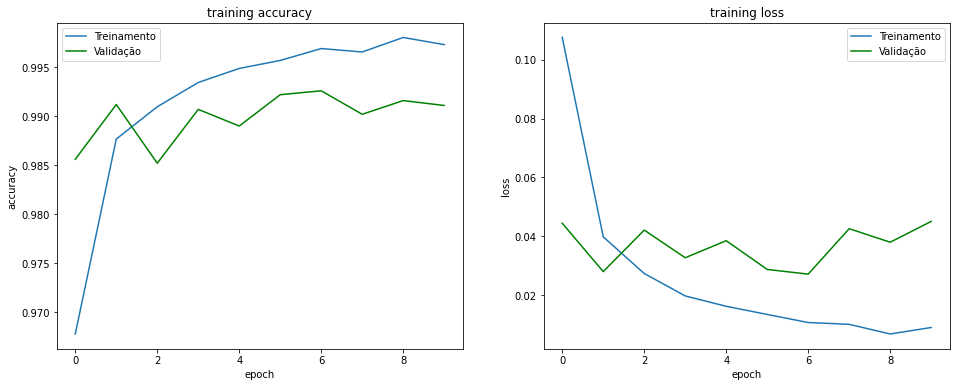

In [39]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.xlabel('epoch')
plt.show()

In [38]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(yhat,axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Questão 3 - CIFAR 10

In [40]:
from keras.datasets import cifar10
def load_cifar_data() -> pd.DataFrame:
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()

  # convert from integers to floats
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  # normalize to range 0-1
  X_train = X_train / 255.0
  X_test = X_test / 255.0
  # one hot encode target values
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_cifar_data()

170508288/170498071 [==============================] - 2s 0us/step


In [42]:
from keras.layers import Dense, Dropout, Activation, Flatten

In [45]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1, workers = -1)

Epoch 1/30
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4204 - accuracy: 0.4850 - val_loss: 1.1869 - val_accuracy: 0.6023
Epoch 2/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9658 - accuracy: 0.6567 - val_loss: 0.9943 - val_accuracy: 0.6649
Epoch 3/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7903 - accuracy: 0.7217 - val_loss: 0.8742 - val_accuracy: 0.7026
Epoch 4/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6839 - accuracy: 0.7599 - val_loss: 0.8132 - val_accuracy: 0.7174
Epoch 5/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6026 - accuracy: 0.7885 - val_loss: 0.7532 - val_accuracy: 0.7420
Epoch 6/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5427 - accuracy: 0.8079 - val_loss: 0.6882 - val_accuracy: 0.7640
Epoch 7/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4904 - accuracy: 0.8282 - val_loss: 0.7091 - val_accuracy

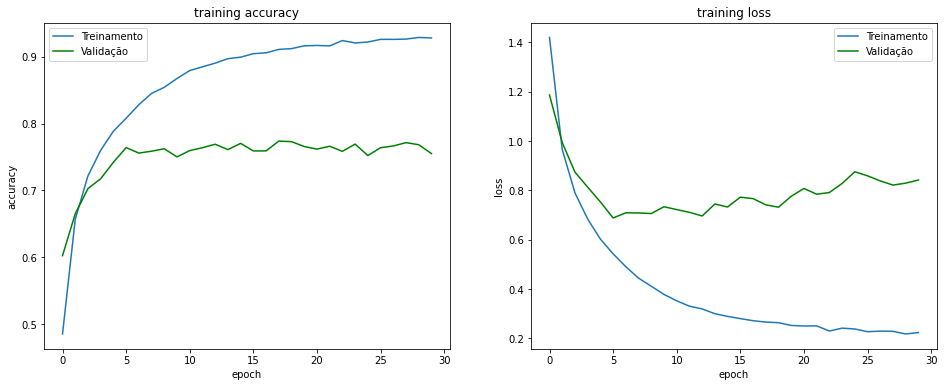

In [46]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.xlabel('epoch')
plt.show()

In [48]:
yhat = model.predict(X_test)
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat,axis=1))
confusion

array([[831,   8,  32,  27,  26,   7,  13,   6,  42,   8],
       [  9, 860,   8,  12,   4,   4,  12,   7,  36,  48],
       [ 58,   1, 656,  57,  68,  63,  73,  15,   6,   3],
       [ 26,   4,  60, 572,  54, 167,  81,  24,   8,   4],
       [ 18,   1,  55,  75, 728,  40,  60,  18,   4,   1],
       [ 11,   5,  42, 159,  30, 698,  38,   9,   4,   4],
       [  7,   1,  38,  54,  24,  21, 847,   1,   6,   1],
       [ 24,   1,  30,  55,  68,  69,  12, 728,   2,  11],
       [ 51,   8,  12,  13,  10,   7,   9,   5, 875,  10],
       [ 46,  67,   9,  38,  11,   6,  18,  11,  39, 755]])

In [49]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(yhat,axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.90      0.86      0.88      1000
           2       0.70      0.66      0.68      1000
           3       0.54      0.57      0.55      1000
           4       0.71      0.73      0.72      1000
           5       0.65      0.70      0.67      1000
           6       0.73      0.85      0.78      1000
           7       0.88      0.73      0.80      1000
           8       0.86      0.88      0.87      1000
           9       0.89      0.76      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

